## LAB_10 - Fine-Tune VGG16 for Bird Classification
### Name: Ramya Chandran
### StudenID: 8895789

In this lab, we will work through a common practice of Deep Learning Engineers - that is - take an existing model, that does something similar to what the engineer is interested doing, and fine-tune it for the specific task at-hand. 

This lab is the last one, so it is a bit more elaborated than the others. So make sure to take time to work through it.

A good starting point is to use the code in the notebook we went over in class - for fine-tuning VGG16. 

The goal of this lab is to achieve the best classification performance over three classes (species) of birds. This should be done by exploring data augmentation and fine-tuning of a pre-trained model (VGG16). Finally, explore and describe the results. 

If you are interested, you are encouraged to explore various training configurations, and see which one works better.

1. Obtain the Data
    1. Download the [BIRDS 525 SPECIES](https://www.kaggle.com/datasets/gpiosenka/100-bird-species?select=train) dataset from Kaggle (CC0 license). You will need to create a free Kaggle account, and this will provide you free access to many such datasets, as well as code and even online notebooks. 
    2. Unpack the data. Notice that the data is organized into folders in a way similar to the Dogs vs Cats dataset that we worked with. This makes it easy to load with the same Keras function (`ImageDataGenerator.flow_from_directory`). 
    3. For this lab, we will work with the 3 classes with the highest number of images. Identify those classes, and use only these for the next steps. You can delete/discard the others.


In [63]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
from keras.utils import to_categorical
from sklearn.preprocessing import label_binarize
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
import pathlib
import matplotlib.pyplot as plt
import os
import shutil
from collections import Counter

In [64]:

# Obtain the Data
data_dir = '/Users/ramyachandran/Documents/MLFoundation/CSCN8010-lab-submissions/archive'
train_dir = os.path.join(data_dir, 'train')

# Identify Top 3 Classes
def count_images_per_class(directory):
    class_counts = Counter()
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            num_images = len(os.listdir(class_path))
            class_counts[class_name] = num_images
    return class_counts

class_counts = count_images_per_class(train_dir)
top_3_classes = sorted(class_counts, key=class_counts.get, reverse=True)[:3]

print("Top 3 Classes:", top_3_classes)


Top 3 Classes: ['WOOD DUCK', 'CASPIAN TERN', 'RED BILLED TROPICBIRD']


2) Use data-augmentation to increase the number of training and validation images. You are encouraged to try out various augmentation methods supported by Keras. The rule of thumb is that as long as an augmentation produces realistic images - it is probably a good idea to add it.(2 point)

In [65]:
# Data Augmentation
batch_size = 32
input_size = (224, 224)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)


In [66]:

# Train, Validation, and Test Data Generators
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'valid')
test_dir = os.path.join(data_dir, 'test')

top_3_classes = ['WOOD DUCK', 'CASPIAN TERN', 'RED BILLED TROPICBIRD'] 

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_size,
    batch_size=batch_size,
    class_mode='categorical',
    classes=top_3_classes
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=input_size,
    batch_size=batch_size,
    class_mode='categorical',
    classes=top_3_classes,
    shuffle=False
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=input_size,
    batch_size=batch_size,
    class_mode='categorical',
    classes=top_3_classes,
    shuffle=False
)

Found 639 images belonging to 3 classes.
Found 15 images belonging to 3 classes.
Found 15 images belonging to 3 classes.


3. Fine-Tune `VGG16` (pre-trained on `imagenet`), to classify the 3 classes (2 points)

In [67]:
# Fine-Tune VGG16
num_classes = len(train_generator.class_indices)

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 10
model.fit(train_generator, epochs=epochs, validation_data=validation_generator)


Epoch 1/10
20/20 [==============================] - 5s 225ms/step - loss: 0.9832 - accuracy: 0.5227 - val_loss: 0.5402 - val_accuracy: 0.9333
Epoch 2/10
20/20 [==============================] - 4s 196ms/step - loss: 0.5906 - accuracy: 0.7809 - val_loss: 0.2950 - val_accuracy: 1.0000
Epoch 3/10
20/20 [==============================] - 4s 190ms/step - loss: 0.4665 - accuracy: 0.8357 - val_loss: 0.2516 - val_accuracy: 0.9333
Epoch 4/10
20/20 [==============================] - 4s 187ms/step - loss: 0.4046 - accuracy: 0.8482 - val_loss: 0.2167 - val_accuracy: 0.9333
Epoch 5/10
20/20 [==============================] - 4s 187ms/step - loss: 0.3561 - accuracy: 0.8748 - val_loss: 0.2390 - val_accuracy: 0.8000
Epoch 6/10
20/20 [==============================] - 4s 192ms/step - loss: 0.3393 - accuracy: 0.8638 - val_loss: 0.1801 - val_accuracy: 0.8667
Epoch 7/10
20/20 [==============================] - 4s 192ms/step - loss: 0.3093 - accuracy: 0.8889 - val_loss: 0.1912 - val_accuracy: 0.8667
Epoch 

4. Explore the model performance: accuracy, confusion metric, precision, recall, F1-score, precision-recall curve and its area under the curve (AUC). Explore specific examples in which the model failed to predict correctly. (2 points)

In [68]:
#  Model Performance Evaluation
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

accuracy = np.mean(y_pred == y_true)
confusion = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=top_3_classes)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", confusion)
print("Classification Report:\n", report)


1/1 [==============================] - 0s 113ms/step
Accuracy: 1.0
Confusion Matrix:
 [[5 0 0]
 [0 5 0]
 [0 0 5]]
Classification Report:
                        precision    recall  f1-score   support

            WOOD DUCK       1.00      1.00      1.00         5
         CASPIAN TERN       1.00      1.00      1.00         5
RED BILLED TROPICBIRD       1.00      1.00      1.00         5

             accuracy                           1.00        15
            macro avg       1.00      1.00      1.00        15
         weighted avg       1.00      1.00      1.00        15



In [69]:
# Step 8: Analyze Model Failures
misclassified_indices = np.where(y_pred != y_true)[0]

for idx in misclassified_indices:
    image_path = test_generator.filepaths[idx]
    true_label = top_3_classes[y_true[idx]]
    predicted_label = top_3_classes[y_pred[idx]]

    img = load_img(image_path, target_size=input_size)
    img_array = img_to_array(img)
    plt.imshow(img_array / 255.0)
    plt.title(f'True Label: {true_label}, Predicted Label: {predicted_label}')
    plt.axis('off')
    plt.show()

In [70]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

Epoch 1/10
20/20 [==============================] - 4s 189ms/step - loss: 0.2451 - accuracy: 0.9077 - val_loss: 0.1150 - val_accuracy: 1.0000
Epoch 2/10
20/20 [==============================] - 4s 187ms/step - loss: 0.2290 - accuracy: 0.9233 - val_loss: 0.1097 - val_accuracy: 1.0000
Epoch 3/10
20/20 [==============================] - 4s 188ms/step - loss: 0.2190 - accuracy: 0.9155 - val_loss: 0.1192 - val_accuracy: 1.0000
Epoch 4/10
20/20 [==============================] - 4s 186ms/step - loss: 0.2130 - accuracy: 0.9218 - val_loss: 0.1341 - val_accuracy: 1.0000
Epoch 5/10
20/20 [==============================] - 4s 187ms/step - loss: 0.2068 - accuracy: 0.9202 - val_loss: 0.1310 - val_accuracy: 1.0000
Epoch 6/10
20/20 [==============================] - 4s 187ms/step - loss: 0.2014 - accuracy: 0.9171 - val_loss: 0.1193 - val_accuracy: 0.9333
Epoch 7/10
20/20 [==============================] - 4s 188ms/step - loss: 0.2019 - accuracy: 0.9202 - val_loss: 0.0947 - val_accuracy: 1.0000
Epoch 

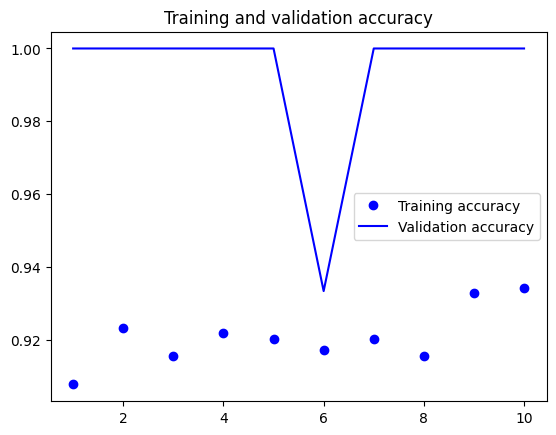

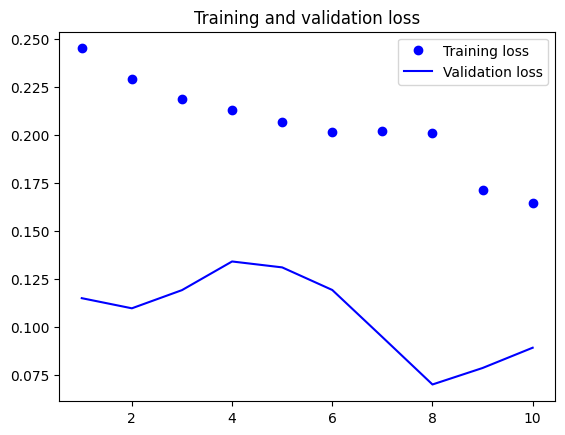

In [71]:
# Accuracy for training and validation
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()